In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyprojroot import here

from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df.drop(['EJ'], axis = 1, inplace = True)
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])
train_df['Epsilon'] = train_df['Epsilon'].apply(lambda x: x.toordinal() - 734640)
train_df.reset_index(drop = True, inplace = True)

In [7]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Beta', 'Delta', 'Gamma', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']

alpha_encoder = LabelEncoder()
y_train_alpha = alpha_encoder.fit_transform(train_df['Alpha'])
alpha_encoder = LabelEncoder()
y_train_beta = alpha_encoder.fit_transform(train_df['Alpha'])
alpha_encoder = LabelEncoder()
y_train_delta = alpha_encoder.fit_transform(train_df['Delta'])
alpha_encoder = LabelEncoder()
y_train_gamma = alpha_encoder.fit_transform(train_df['Gamma'])

In [17]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

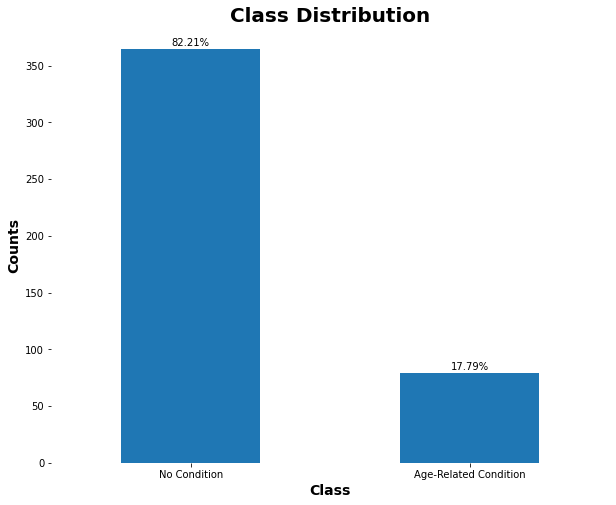

In [150]:
# counts by outcome class
plt.figure(figsize=(10, 8))

class_counts = train_df['Class'].value_counts()
class_counts.plot(kind = 'bar')

plt.title('Class Distribution', fontdict = font_dict_header)
plt.xlabel('Class', fontdict = font_dict_axistitle)
label_dict = {0: 'No Condition', 1: 'Age-Related Condition'}
plt.xticks(rotation = 0, ticks = train_df['Class'].unique(), labels = [label_dict[i] for i in train_df['Class'].unique()])
plt.ylabel('Counts', fontdict=font_dict_axistitle)

total_count = float(len(train_df))
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2.,
             height + 3,
             '{:1.2f}%'.format((height/total_count) * 100),
             ha = 'center') 

plt.box(False)
plt.show()

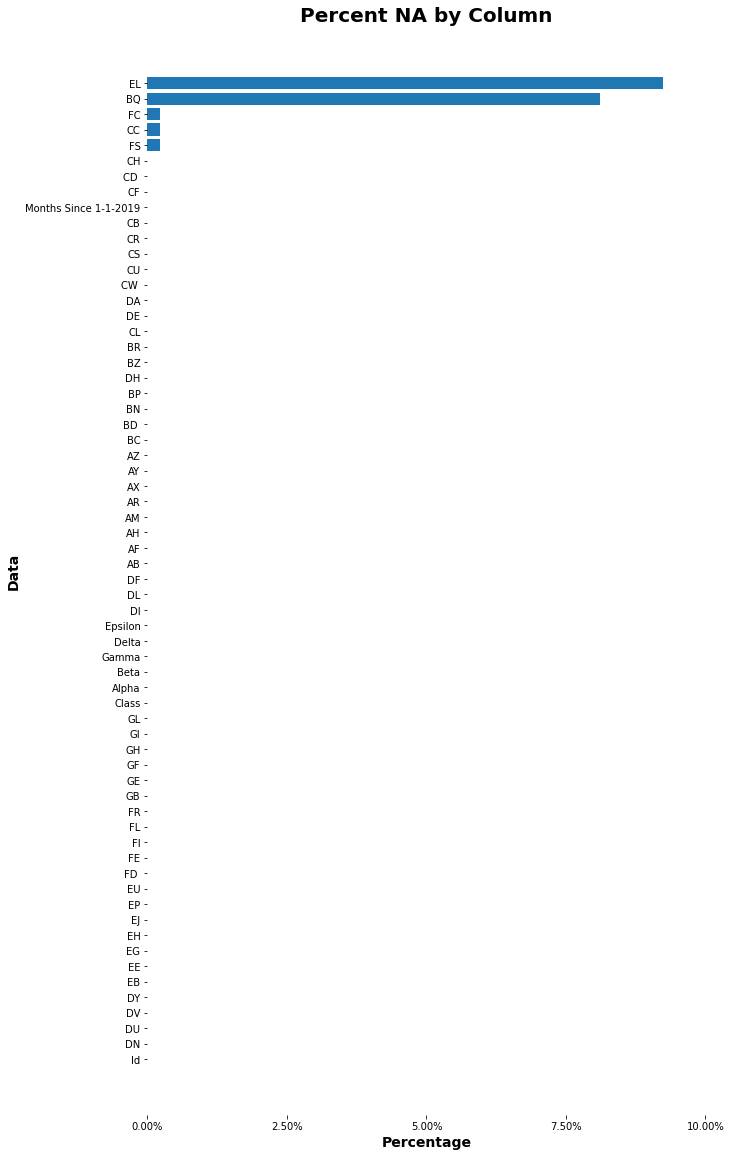

In [151]:
# missing values
na_by_column = train_df.isnull().sum().reset_index()
na_by_column.columns = ['Column', 'Count NA']
na_by_column['Percent NA'] = na_by_column['Count NA'] / len(train_df)
na_by_column = na_by_column.sort_values('Percent NA', ascending=True) 

plt.figure(figsize = [10, 20])
plt.barh(data = na_by_column, y = 'Column', width = 'Percent NA')
plt.box(False)

x_max = na_by_column['Percent NA'].max()
x_increments = 0.025
x_ticks = np.arange(0, x_max + x_increments, x_increments)

plt.xlabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(ticks = x_ticks, labels = ['{:1.2f}%'.format(tick * 100) for tick in x_ticks])
plt.ylabel('Data', fontdict = {'size': 14, 'weight': 'bold'})
plt.title('Percent NA by Column', fontdict = {'size': 20, 'weight': 'bold'})
plt.show()


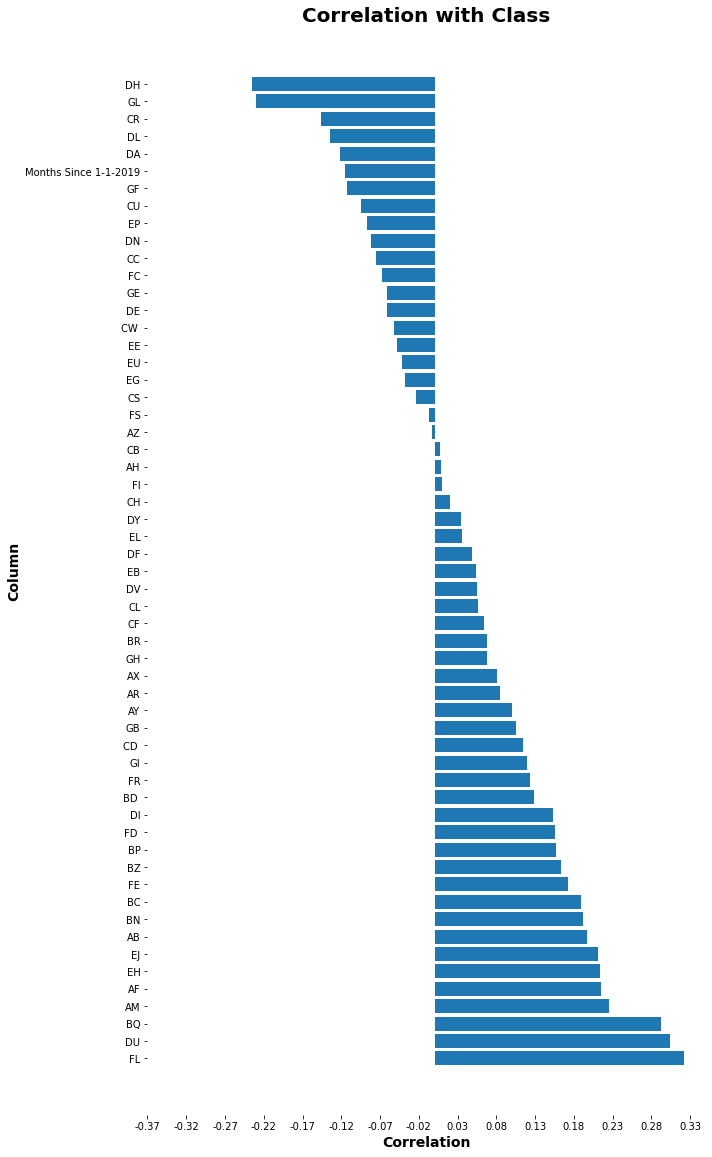

In [152]:
# finding linear correlations
correlations_with_class = train_df[train_df.select_dtypes(include = ['int64', 'float64']).columns].corr()['Class'].sort_values(ascending = False)
correlations_with_class.drop('Class', inplace = True)
correlations_with_class = pd.DataFrame(correlations_with_class).reset_index().rename(columns = {'index': 'Column', 'Class': 'Correlation with Class'})

plt.figure(figsize = [10, 20])
plt.title('Correlation with Class', fontdict = {'size': 20, 'weight': 'bold'})
plt.barh(data = correlations_with_class, y = 'Column', width = 'Correlation with Class')
plt.box(False)

x_max = max([correlations_with_class['Correlation with Class'].max(), abs(correlations_with_class['Correlation with Class'].min())])
x_increments = 0.05
x_ticks = np.arange((x_max + x_increments) * -1, x_max + x_increments, x_increments)

plt.xlabel('Correlation', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(ticks = x_ticks, labels = [np.round(tick, 2) for tick in x_ticks])
plt.ylabel('Column', fontdict = {'size': 14, 'weight': 'bold'})
plt.show()

In [153]:
# explain categorical variables
EJ_df = train_df.groupby('EJ').agg({'Class': ['mean', 'count']})
EJ_df.columns = [' '.join(col).strip() for col in EJ_df.columns.values]
EJ_df.reset_index(inplace = True)
EJ_df.rename(columns = {'Class mean': 'Mean', 'Class count': 'Count'}, inplace = True)

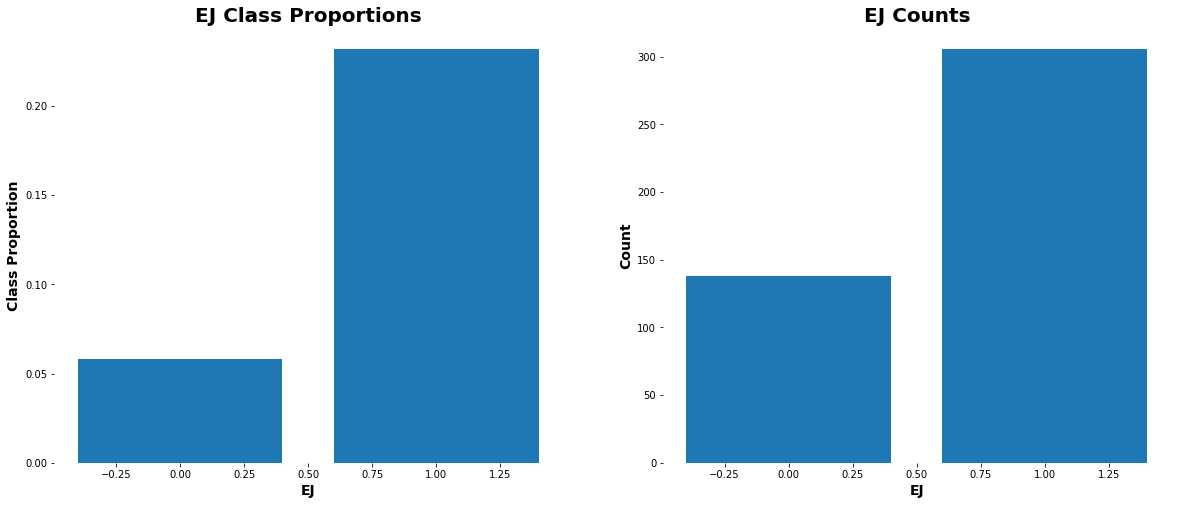

In [154]:
# plot proportion and count
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('EJ Class Proportions', fontdict = font_dict_header)
plt.bar(data = EJ_df, x = 'EJ', height = 'Mean')
plt.box(False)
plt.xlabel('EJ', fontdict = font_dict_axistitle)
plt.ylabel('Class Proportion', fontdict = font_dict_axistitle)

plt.subplot(1, 2, 2)
plt.title('EJ Counts', fontdict = font_dict_header)
plt.bar(data = EJ_df, x = 'EJ', height = 'Count')
plt.box(False)
plt.xlabel('EJ', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)

plt.show()

In [155]:
# pre-process data
y_train = train_df['Class']

x_train = train_df.select_dtypes(include = [np.number])
x_train = x_train.drop(['Class'], axis = 1, inplace = False)

# normalize data
x_train_columns = x_train.columns
x_train_index = x_train.index
x_train = PowerTransformer().fit_transform(x_train)
x_train = StandardScaler().fit_transform(x_train)
x_train = KNNImputer().fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = x_train_columns, index = x_train_index)

In [165]:
pca_fit_columns

['FL',
 'DU',
 'BQ',
 'AM',
 'AF',
 'EH',
 'EJ',
 'AB',
 'BN',
 'BC',
 'FE',
 'BZ',
 'BP',
 'FD ',
 'DI',
 'BD ',
 'FR',
 'GL',
 'DH']

Number of Principal Components: 12
Total Explained Variance: 100.0%


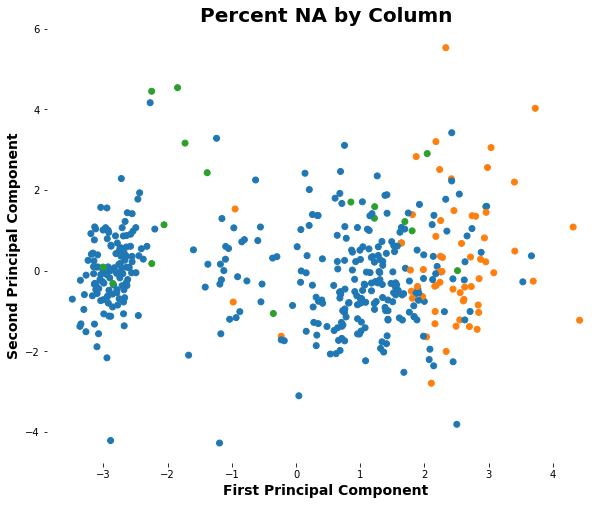

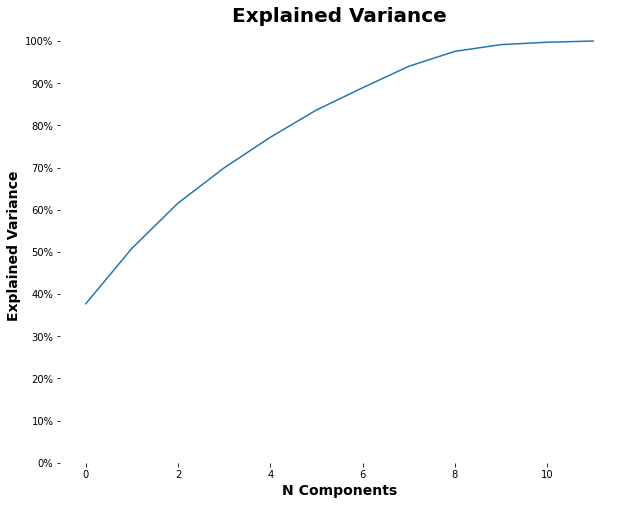

In [170]:
# PCA
pca_fit_columns = correlations_with_class[(correlations_with_class['Correlation with Class'] > 0.2) | (correlations_with_class['Correlation with Class'] < -0.12)]['Column'].tolist()

pca_n = len(pca_fit_columns)
pca = PCA(n_components = pca_n) 
principal_components = pca.fit_transform(x_train[pca_fit_columns])
pca_columns = ['Principal Component ' + str(i + 1) for i in range(pca_n)]

pca_df = pd.DataFrame(data = principal_components, columns = pca_columns)
pca_df['Class'] = y_train

# print explained variance
print(f'Number of Principal Components: {pca_n}')
print(f'Total Explained Variance: {np.round(sum(pca.explained_variance_ratio_) * 100, 2)}%')

color_dict = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
colors = train_df['Alpha'].map(color_dict)

# plot PCA and explained variance
plt.figure(figsize = (10, 8))
plt.title('Percent NA by Column', fontdict = font_dict_header)
plt.box(False)
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c = colors)
plt.xlabel('First Principal Component', fontdict = font_dict_axistitle)
plt.ylabel('Second Principal Component', fontdict = font_dict_axistitle)
plt.show()

plt.figure(figsize = (10, 8))
plt.title('Explained Variance', fontdict = font_dict_header)
plt.box(False)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('N Components', fontdict = font_dict_axistitle)
plt.ylabel('Explained Variance', fontdict = font_dict_axistitle)
plt.yticks(np.arange(0, 1.1, 0.1), labels = ['{:1.0f}%'.format(tick * 100) for tick in np.arange(0, 1.1, 0.1)])
plt.show()

In [162]:
# create df of the PCA components
pca_components_df = pd.DataFrame(pca.components_, columns = x_train_columns, index = pca_columns)
pca_components_df.abs().T.sort_values(by = 'Principal Component 1', ascending = False).head(10)

ValueError: Shape of passed values is (19, 19), indices imply (19, 57)

In [101]:
df = train_df.drop(['Class', 'Alpha', 'Beta', 'Gamma', 'Delta'], axis = 1, inplace = False)

imputer = SimpleImputer(strategy = 'median')
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns = df.columns, index = df.index)



In [64]:
tier_1_predictive_features = ['EP', 'CR', 'AY', 'AB', 'DU', 'DA', 'DI', 'DH', 'BC', 'DL', 'EE', 'BQ', 'Epsilon']

In [67]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
gamma_color_map = {'M': 'C0', 'N': 'C1', 'H': 'C2', 'B': 'C3', 'A': 'C4', 'F': 'C5', 'G': 'C6', 'E': 'C7'}

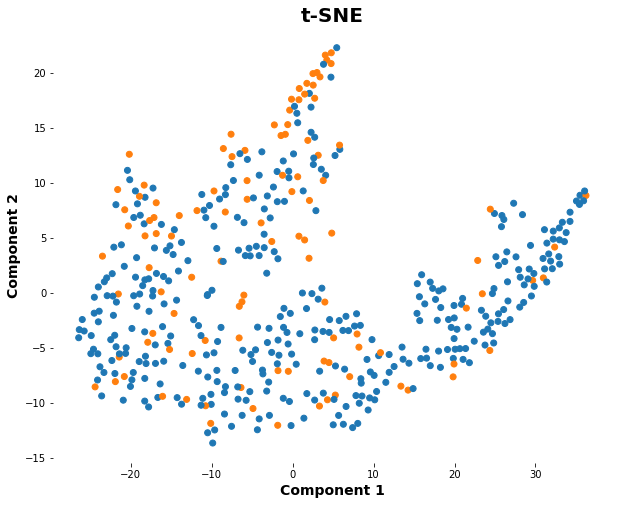

In [102]:
# t-SNE
train_df
tsne_n = 2
tsne = TSNE(n_components = tsne_n)
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
x_tsne = tsne.fit_transform(df)
tsne.fit(df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = x_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class

colors = train_df['Class'].map(class_color_map)

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

In [103]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def get_closest_same_class(df, point):
    distances = []
    for i, row in df.iterrows():
        if i != point:
            dist = euclidean_distance([df.loc[point, 'Component 1'], df.loc[point, 'Component 2']], [row['Component 1'], row['Component 2']])
            distances.append((dist, i, row['Class']))
    distances.sort()  
    for i, (dist, idx, cls) in enumerate(distances):
        if cls == df.loc[point, 'Class']:
            return i, dist
    return -1, np.inf


In [104]:
tsne_neighbor = {}
tsne_neighbor_dist = {}
for i, row in tsne_df.iterrows():
    idx, dist = get_closest_same_class(tsne_df, i)
    tsne_neighbor[i] = idx
    tsne_neighbor_dist[i] = dist

In [105]:
tsne_df['TSNE Neighbor'] = pd.Series(tsne_neighbor)
tsne_df['TSNE Neighbor Distance'] = pd.Series(tsne_neighbor_dist)

In [ ]:
114

In [80]:
tsne_df.loc[114]

Component 1        5.841365
Component 2       13.628035
Class              1.000000
TSNE Neighbors     2.000000
Name: 114, dtype: float64

In [106]:
tsne_df[tsne_df['Class'] == 1].sort_values(by = 'Z Average', ascending = False).head(30)

,Component 1,Component 2,Class,TSNE Neighbor,TSNE Neighbor Distance,Neighbor Z Score,Neighbor Distance Z Score,Z Average
339,24.361883,-5.236995,1,23,4.592830,4.436661,2.627228,3.531945
172,36.240894,8.848114,1,15,6.077551,2.616492,4.015025,3.315759
129,-21.542662,-0.104274,1,21,3.960421,3.981619,2.036103,3.008861
388,32.373726,4.159656,1,18,3.127821,3.299056,1.257856,2.278456
187,24.418613,7.605116,1,8,4.913456,1.023845,2.926923,1.975384
398,-12.478722,1.419952,1,11,3.906986,1.706408,1.986156,1.846282
441,-23.503119,3.336880,1,10,3.960421,1.478887,2.036103,1.757495
131,3.977630,-0.835533,1,12,3.429939,1.933929,1.540252,1.737091
243,-8.854974,2.880427,1,10,3.906986,1.478887,1.986156,1.732522
371,-1.846142,-12.035560,1,8,3.415462,1.023845,1.526720,1.275282


In [22]:
import umap

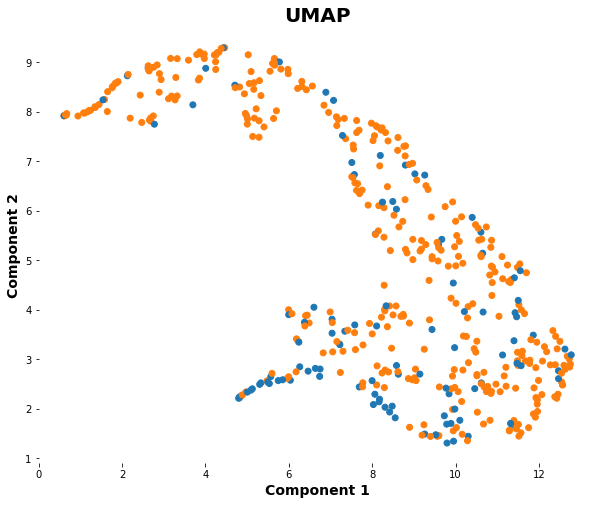

In [26]:
# umap
umap_n = 2
reducer = umap.UMAP(n_components = umap_n)
umap_columns = ['Component ' + str(i + 1) for i in range(umap_n)]
x_umap = reducer.fit_transform(df)

# create df with the UMAP components and 'Class'
umap_df = pd.DataFrame(data = x_umap, columns = umap_columns)
umap_df['Class'] = y_train_class

color_dict = {1: 'C0', 0: 'C1', 'D': 'C2', 'G': 'C3'}
colors = train_df['Class'].map(color_dict)

# plot components
plt.figure(figsize = (10, 8))
plt.title('UMAP', fontdict = font_dict_header)
plt.box(False)
plt.scatter(umap_df['Component 1'], umap_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()


In [120]:
# create counts by Alpha values
alpha_counts = train_df.groupby(['Epsilon', 'Alpha']).agg({'Id': 'count'}).reset_index().rename(columns = {'Id': 'Count'})
alpha_counts = alpha_counts.groupby([pd.Grouper(key = 'Epsilon', freq = 'M'), 'Alpha']).agg({'Count': 'sum'}).unstack().reset_index().fillna(0)
alpha_counts = alpha_counts[alpha_counts['Epsilon'] >= '2018-01-01']
alpha_counts = alpha_counts.set_index('Epsilon').resample('M').ffill()
alpha_counts.columns = alpha_counts.columns.droplevel(0)
alpha_counts.reset_index(inplace = True)

In [122]:
alpha_counts

Alpha,Epsilon,A,B,D,G
0,2018-01-31,0.0,3.0,0.0,0.0
1,2018-02-28,0.0,1.0,0.0,0.0
2,2018-03-31,0.0,1.0,0.0,0.0
3,2018-04-30,0.0,1.0,0.0,0.0
4,2018-05-31,0.0,1.0,0.0,0.0
5,2018-06-30,0.0,1.0,0.0,0.0
6,2018-07-31,1.0,0.0,0.0,0.0
7,2018-08-31,0.0,1.0,0.0,0.0
8,2018-09-30,0.0,3.0,0.0,1.0
9,2018-10-31,3.0,0.0,0.0,0.0


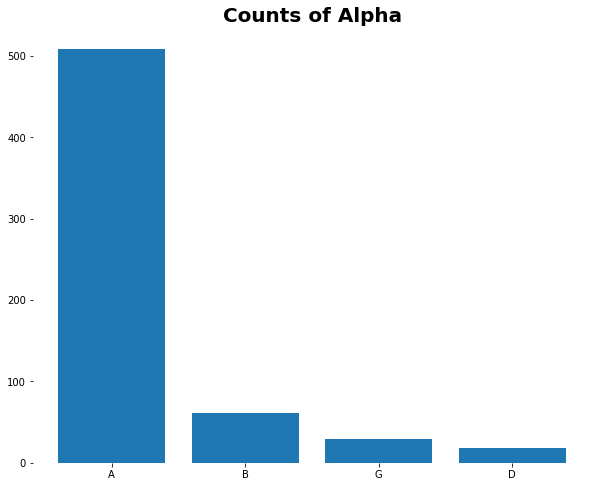

In [228]:
# plot Alpha counts
plt.figure(figsize = (10, 8))
plt.title('Counts of Alpha', fontdict = font_dict_header)
plt.box(False)
plt.bar(x = train_with_greeks_df['Alpha'].value_counts().index, height = train_with_greeks_df['Alpha'].value_counts())
plt.show()

In [111]:
alpha_counts

NameError: name 'alpha_counts' is not defined

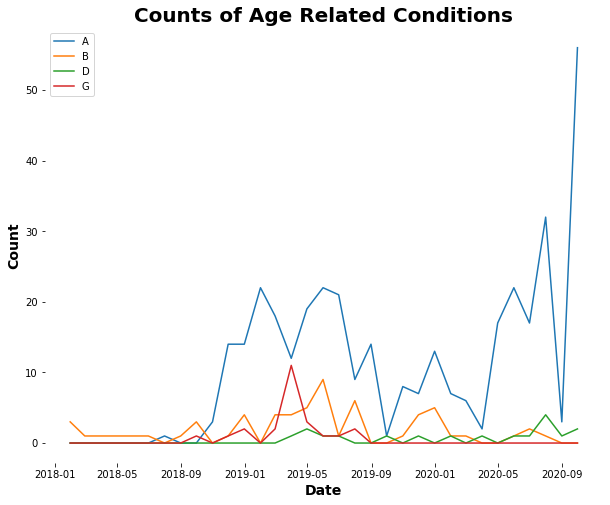

In [121]:
# plot Alpha counts over time
plt.figure(figsize = (10, 8))
plt.title('Counts of Age Related Conditions', fontdict = font_dict_header)
plt.box(False)
plt.plot(alpha_counts['Epsilon'], alpha_counts['A'], label = 'A')
plt.plot(alpha_counts['Epsilon'], alpha_counts['B'], label = 'B')
plt.plot(alpha_counts['Epsilon'], alpha_counts['D'], label = 'D')
plt.plot(alpha_counts['Epsilon'], alpha_counts['G'], label = 'G')
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.xlabel('Date', fontdict = font_dict_axistitle)
plt.legend()
plt.show()

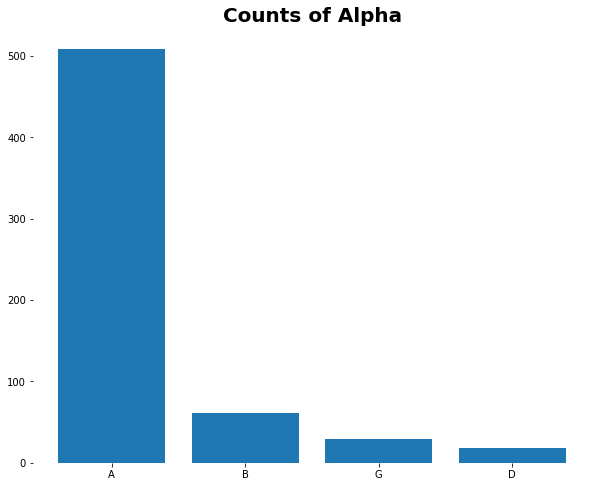

In [230]:
plt.figure(figsize = (10, 8))
plt.title('Counts of Alpha', fontdict = font_dict_header)
plt.box(False)
plt.bar(x = train_with_greeks_df['Alpha'].value_counts().index, height = train_with_greeks_df['Alpha'].value_counts())
plt.show()

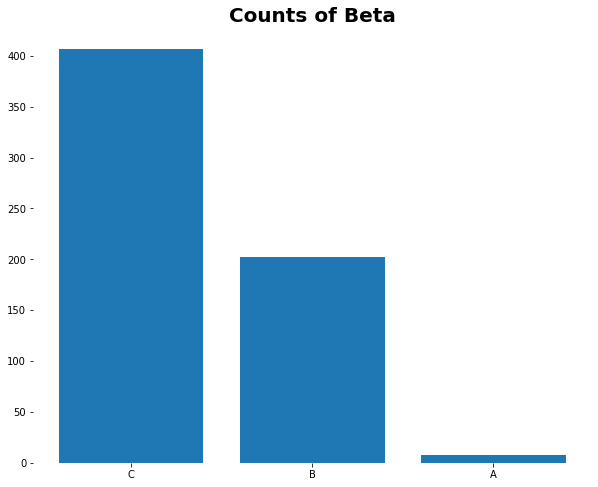

In [231]:
plt.figure(figsize = (10, 8))
plt.title('Counts of Beta', fontdict = font_dict_header)
plt.box(False)
plt.bar(x = train_with_greeks_df['Beta'].value_counts().index, height = train_with_greeks_df['Beta'].value_counts())
plt.show()

In [124]:
cat_cols = ['Alpha', 'Beta', 'Gamma', 'Delta']

In [135]:
# print the unique values for each categorical column sorted alphabetically
label_dic = {}
for col in cat_cols:
    values = train_df[col].unique().tolist()
    values.sort()
    label_dic[col] = values

In [138]:
train_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon,Months Since 1-1-2019
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,22.136229,69.834944,0.120343,1,B,C,G,D,2019-03-19,2
1,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,45.381316,36.262628,0.096614,1,D,B,F,B,2020-03-25,14
2,04517a3c90bd,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,...,28.525186,82.527764,21.978000,0,A,C,M,B,2019-10-01,9
3,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,34.166222,100.086808,0.065096,0,A,C,M,B,2019-05-29,4
4,057287f2da6d,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,...,35.208102,31.424696,0.092873,0,A,C,M,B,2019-04-24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,38.380254,41.007968,21.978000,0,A,B,M,B,2020-06-11,17
469,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,24.640462,69.191944,21.978000,0,A,B,M,B,2020-09-13,20
470,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,29.648928,124.808872,0.145340,0,A,B,M,B,2020-09-08,20
471,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,26.166072,119.559420,21.978000,0,A,C,M,B,2019-07-24,6


In [136]:
import seaborn as sns

Alpha
--------------------
Percent NA: 0.0%


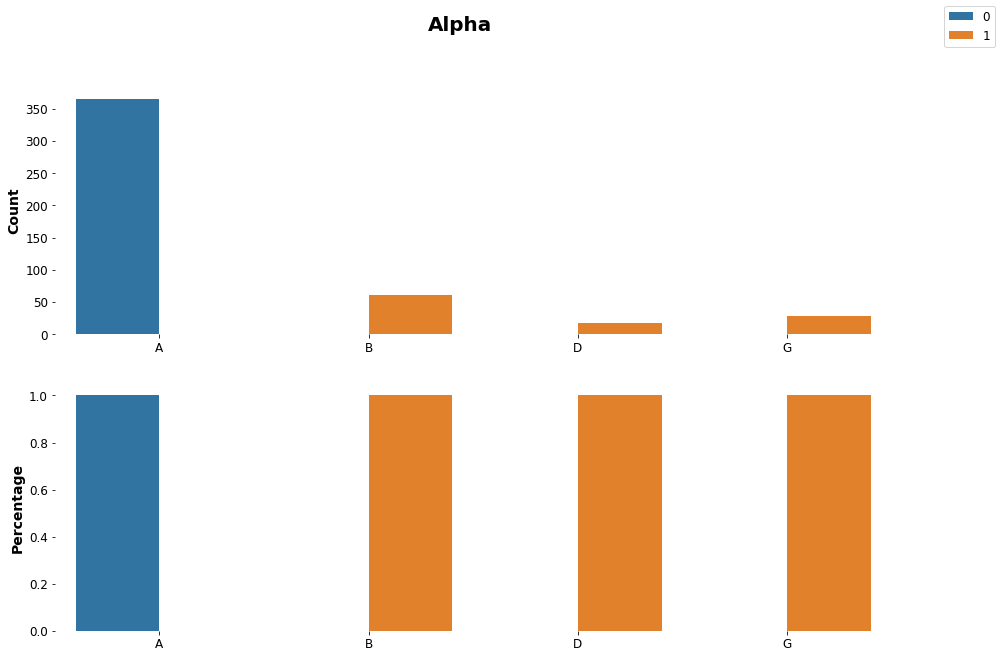

Beta
--------------------
Percent NA: 0.0%


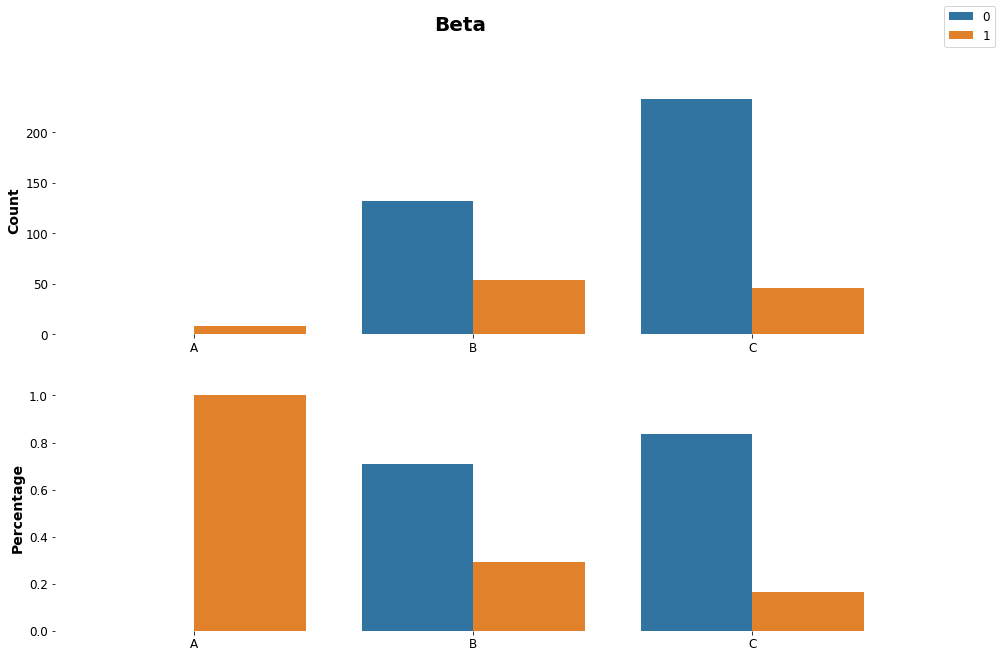

Gamma
--------------------
Percent NA: 0.0%


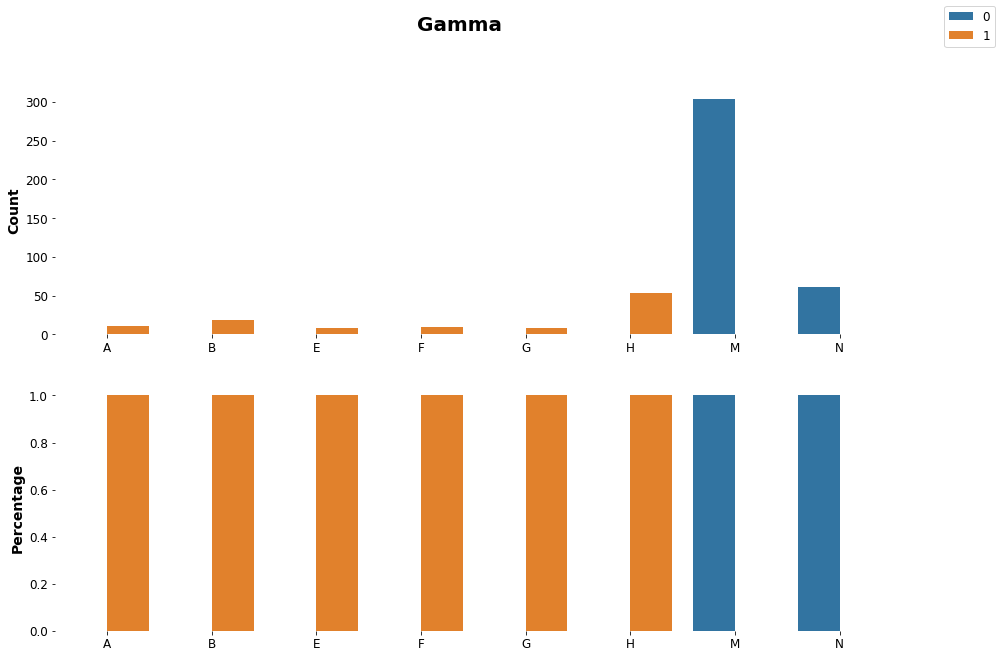

Delta
--------------------
Percent NA: 0.0%


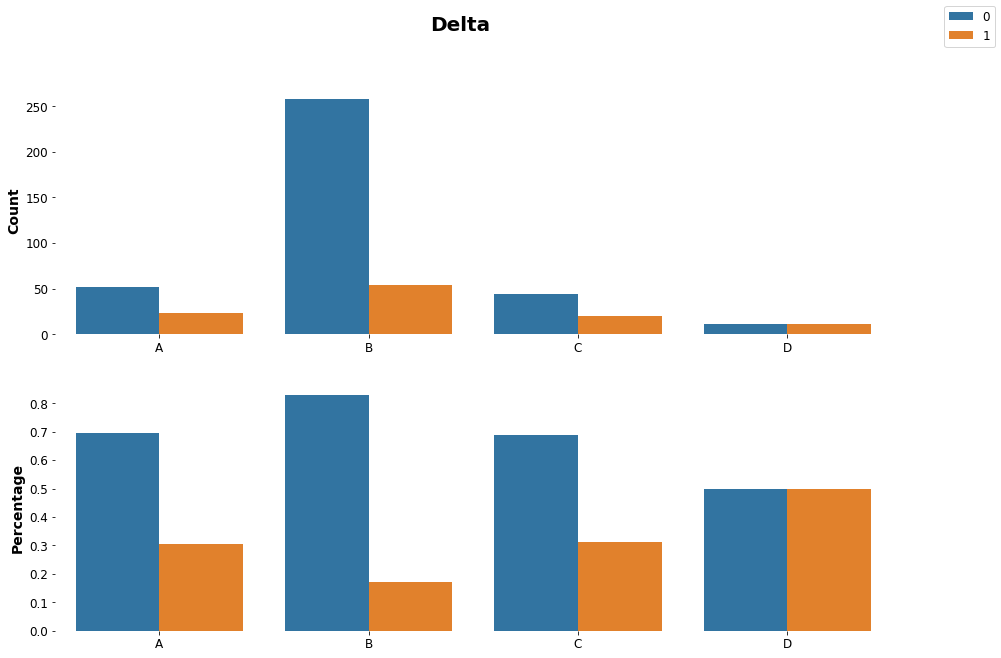

In [139]:
for col in cat_cols:
    # creating dictionary for visualization x axis order
    
    # printing out descriptive statistics
    print(col)
    print('--------------------')
    print('Percent NA: ', round((train_df[col].isnull().sum() / len(train_df)) * 100, 2), '%', sep = '')
    
    # initializing figure
    plt.figure(figsize = (15, 10))
    plt.suptitle(col, size = 20, weight = 'bold')
    
    # plot 1: bar plot with counts
    plt.subplot(2, 1, 1)

    sns.countplot(x = train_df[col], hue = train_df['Class'], order = label_dic[col])
    plt.legend('', framealpha = 0)
    plt.box(False)
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    plt.figlegend(fontsize = 12)
    
    # plot 2: bar plot with percentages
    plt.subplot(2, 1, 2)
    
    # calculating percentages by category
    counts_total = pd.DataFrame(train_df.groupby([col]).count()['Id']).reset_index()
    counts = pd.DataFrame(train_df.groupby([col,'Class']).count()['Id']).reset_index()
    counts = pd.merge(counts, counts_total, on = col, suffixes = ['', '_Total'])
    counts['Percentage_By_Column'] = counts['Id'] / counts['Id_Total']
    
    sns.barplot(x = counts[col], y = counts['Percentage_By_Column'], hue = counts['Class'], order = label_dic[col])
    plt.legend('', framealpha = 0)
    plt.box(False)
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    
    plt.show()